In [2]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import glob
import torch
import torchvision
import torch.nn.functional as F
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from PIL import Image
from tempfile import TemporaryDirectory
from time import time
from tqdm import tqdm
from torch.optim import lr_scheduler

In [3]:
torch.set_default_dtype(torch.float32)

In [4]:
data_root = "/Users/kimdeok-hwi/deeplearning/data/MNIST/raw/dog's_breed/images/"
file_root = f'{data_root}/Images'
train_root = f'{data_root}/train'
valid_root = f'{data_root}/valid'
test_root = f'{data_root}/test'

In [5]:
cls_list = os.listdir(file_root)
cls_list

['n02097658-silky_terrier',
 'n02092002-Scottish_deerhound',
 'n02099849-Chesapeake_Bay_retriever',
 'n02091244-Ibizan_hound',
 'n02095314-wire-haired_fox_terrier',
 'n02091831-Saluki',
 'n02102318-cocker_spaniel',
 'n02104365-schipperke',
 'n02090622-borzoi',
 'n02113023-Pembroke',
 'n02105505-komondor',
 'n02093256-Staffordshire_bullterrier',
 'n02113799-standard_poodle',
 'n02109961-Eskimo_dog',
 'n02089973-English_foxhound',
 'n02099601-golden_retriever',
 'n02095889-Sealyham_terrier',
 'n02085782-Japanese_spaniel',
 'n02097047-miniature_schnauzer',
 'n02110063-malamute',
 'n02105162-malinois',
 'n02086079-Pekinese',
 'n02097130-giant_schnauzer',
 'n02113978-Mexican_hairless',
 'n02107142-Doberman',
 'n02097209-standard_schnauzer',
 'n02115913-dhole',
 'n02106662-German_shepherd',
 'n02106382-Bouvier_des_Flandres',
 'n02110185-Siberian_husky',
 'n02094258-Norwich_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02109525-Saint_Bernard',
 'n02093754-Border_terri

In [6]:
for folder in [train_root, valid_root, test_root]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    for cls in cls_list:
        cls_folder = f'{folder}/{cls}'
        if not os.path.exists(cls_folder):
            os.makedirs(cls_folder)

In [7]:
random.seed(2024)

In [8]:
for cls in cls_list:
    file_list = os.listdir(f'{file_root}/{cls}')
    random.shuffle(file_list)
    test_ratio = 0.1
    num_file = len(file_list)

    test_list = file_list[:int(num_file*test_ratio)]
    valid_list = file_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
    train_list = file_list[int(num_file*test_ratio)*2:]

    for i in test_list:
        shutil.copyfile(f'{file_root}/{cls}/{i}', f'{test_root}/{cls}/{i}')

    for i in valid_list:
        shutil.copyfile(f'{file_root}/{cls}/{i}', f'{valid_root}/{cls}/{i}')

    for i in train_list:
        shutil.copyfile(f'{file_root}/{cls}/{i}', f'{train_root}/{cls}/{i}')

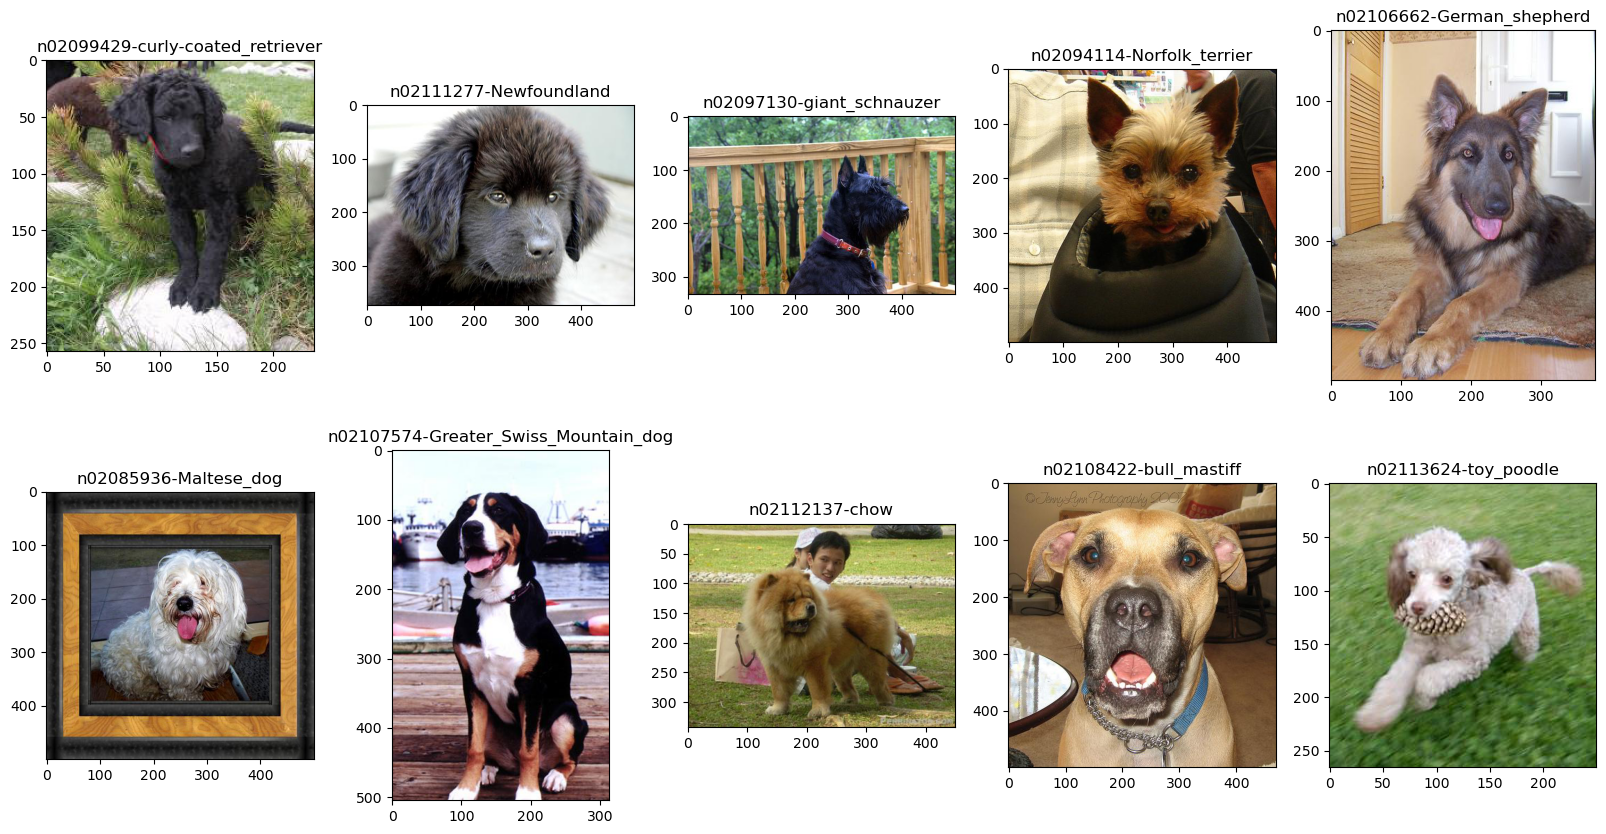

In [25]:
test_file_list = glob.glob(f"{test_root}/*/*")
random.shuffle(test_file_list)

plt.figure(figsize = (20,10))
for i in range(10):
    test_img_path = os.path.join(test_file_list[i])
    ori_img = Image.open(test_img_path).convert('RGB')
    plt.subplot(2, 5, (i+1))
    plt.title(test_file_list[i].split('/')[-2])
    plt.imshow(ori_img)

plt.show()

In [9]:
IMG_SIZE = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [10]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_root, x),
                                          data_transforms[x]) for x in ['train', 'valid', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
               shuffle=True, num_workers=4) for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 16562, 'valid': 2009, 'test': 2009}
['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n020

In [11]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, model_dir, model_name, num_epochs=25):
    print(device)
    since = time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        train_loss = []
        train_acc = []
        valid_loss = []
        valid_acc = []
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                running_loss = 0.0
                running_corrects = 0
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if scheduler is not None and phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                if phase == 'train':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc.item())
                else:
                    valid_loss.append(epoch_loss)
                    valid_acc.append(epoch_acc.item())
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        if not os.path.exists(model_dir):
                            os.makedirs(model_dir)
                        model_save_path = os.path.join(model_dir, f'{model_name}.pth')
                        torch.save(model.state_dict(), model_save_path)
            print()
        time_elapsed = time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')
    return [train_loss, valid_loss, train_acc, valid_acc]

In [12]:
data_root = './images'
model_dir = f'{data_root}/models'
DEVICE = torch.device('cuda' if torch.backends.mps.is_available() else 'cpu')
NUM_EPOCHS = 20
DEVICE

device(type='cuda')

In [13]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

device

device(type='mps')

In [14]:
num_class = len(os.listdir(train_root))
print(num_class)

120


In [24]:
resnet18_model = timm.create_model('resnet18', pretrained = True, num_classes = num_class).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr = 0.0002)
# 학습률 스케줄러 중 하나로, 학습률을 단계적으로 감소시키는 기능
# step_size : 학습률이 감소하는 주기 설정(예 : 10 에폭마다 학습률이 조정됨)
# gamma : 학습률을 감소시킬 비율(예 : 10 에폭마다 0.9배로 줄임)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.9)

In [35]:
resnet18 = train_model(resnet18_model, loss_func, optimizer, scheduler, dataloaders, dataset_sizes, device, model_dir, 'dog_resnet18', num_epochs = NUM_EPOCHS)

mps
Epoch 1/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.61it/s]


train Loss: 4.8067 Acc: 0.0068


100%|██████████| 126/126 [00:27<00:00,  4.63it/s]


valid Loss: 4.8089 Acc: 0.0045

Epoch 2/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.64it/s]


train Loss: 4.8074 Acc: 0.0066


100%|██████████| 126/126 [00:27<00:00,  4.63it/s]


valid Loss: 4.8069 Acc: 0.0035

Epoch 3/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.65it/s]


train Loss: 4.8072 Acc: 0.0075


100%|██████████| 126/126 [00:27<00:00,  4.56it/s]


valid Loss: 4.8070 Acc: 0.0040

Epoch 4/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.64it/s]


train Loss: 4.8082 Acc: 0.0077


100%|██████████| 126/126 [00:27<00:00,  4.62it/s]


valid Loss: 4.8060 Acc: 0.0045

Epoch 5/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.64it/s]


train Loss: 4.8075 Acc: 0.0066


100%|██████████| 126/126 [00:27<00:00,  4.62it/s]


valid Loss: 4.8068 Acc: 0.0045

Epoch 6/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.65it/s]


train Loss: 4.8060 Acc: 0.0069


100%|██████████| 126/126 [00:27<00:00,  4.62it/s]


valid Loss: 4.8080 Acc: 0.0050

Epoch 7/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.66it/s]


train Loss: 4.8066 Acc: 0.0074


100%|██████████| 126/126 [00:27<00:00,  4.61it/s]


valid Loss: 4.8065 Acc: 0.0060

Epoch 8/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.65it/s]


train Loss: 4.8065 Acc: 0.0078


100%|██████████| 126/126 [00:27<00:00,  4.62it/s]


valid Loss: 4.8072 Acc: 0.0035

Epoch 9/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.65it/s]


train Loss: 4.8068 Acc: 0.0071


100%|██████████| 126/126 [00:27<00:00,  4.63it/s]


valid Loss: 4.8057 Acc: 0.0055

Epoch 10/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.65it/s]


train Loss: 4.8063 Acc: 0.0078


100%|██████████| 126/126 [00:27<00:00,  4.62it/s]


valid Loss: 4.8065 Acc: 0.0035

Epoch 11/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.67it/s]


train Loss: 4.8060 Acc: 0.0063


100%|██████████| 126/126 [00:27<00:00,  4.62it/s]


valid Loss: 4.8081 Acc: 0.0045

Epoch 12/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.66it/s]


train Loss: 4.8075 Acc: 0.0074


100%|██████████| 126/126 [00:27<00:00,  4.62it/s]


valid Loss: 4.8080 Acc: 0.0030

Epoch 13/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.67it/s]


train Loss: 4.8065 Acc: 0.0073


100%|██████████| 126/126 [00:27<00:00,  4.64it/s]


valid Loss: 4.8083 Acc: 0.0055

Epoch 14/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.68it/s]


train Loss: 4.8063 Acc: 0.0075


100%|██████████| 126/126 [00:27<00:00,  4.64it/s]


valid Loss: 4.8073 Acc: 0.0045

Epoch 15/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.67it/s]


train Loss: 4.8068 Acc: 0.0065


100%|██████████| 126/126 [00:27<00:00,  4.62it/s]


valid Loss: 4.8071 Acc: 0.0035

Epoch 16/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.67it/s]


train Loss: 4.8058 Acc: 0.0075


100%|██████████| 126/126 [00:27<00:00,  4.61it/s]


valid Loss: 4.8072 Acc: 0.0030

Epoch 17/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.67it/s]


train Loss: 4.8067 Acc: 0.0071


100%|██████████| 126/126 [00:27<00:00,  4.62it/s]


valid Loss: 4.8056 Acc: 0.0040

Epoch 18/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.66it/s]


train Loss: 4.8069 Acc: 0.0078


100%|██████████| 126/126 [00:27<00:00,  4.63it/s]


valid Loss: 4.8059 Acc: 0.0025

Epoch 19/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.66it/s]


train Loss: 4.8065 Acc: 0.0072


100%|██████████| 126/126 [00:27<00:00,  4.61it/s]


valid Loss: 4.8069 Acc: 0.0045

Epoch 20/20
----------


100%|██████████| 1036/1036 [01:47<00:00,  9.66it/s]


train Loss: 4.8067 Acc: 0.0076


100%|██████████| 126/126 [00:27<00:00,  4.63it/s]

valid Loss: 4.8085 Acc: 0.0045

Training complete in 44m 53s
Best val Acc: 0.0060


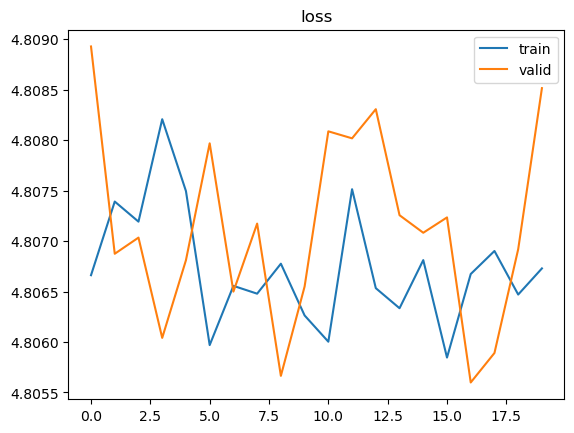

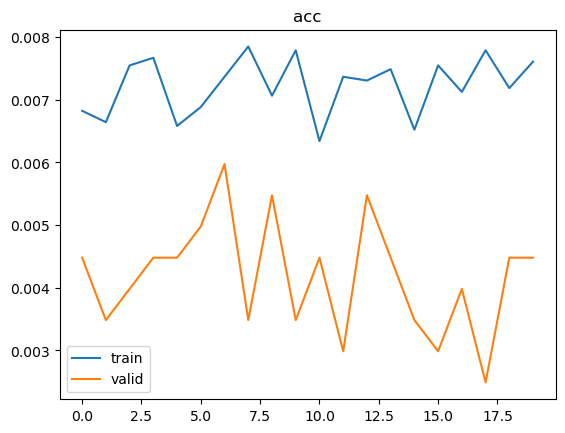

In [36]:
import matplotlib.pyplot as plt
plt.title("loss")
plt.plot(resnet18[0], label='train')
plt.plot(resnet18[1], label='valid')
plt.legend()
plt.show()
plt.title("acc")
plt.plot(resnet18[2], label='train')
plt.plot(resnet18[3], label='valid')
plt.legend()
plt.show()

In [26]:
test_img_path = os.path.join(test_file_list[10])
test_img_path

"/Users/kimdeok-hwi/deeplearning/data/MNIST/raw/dog's_breed/images//test/n02088632-bluetick/n02088632_3923.jpg"

In [27]:
test_data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [28]:
ori_img = Image.open(test_img_path).convert('RGB')
image = test_data_transform(ori_img)
x_tensor = image.to(device).unsqueeze(0)

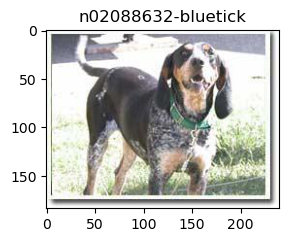

In [33]:
resnet18_model.eval()
with torch.no_grad() :
  outputs = resnet18_model(x_tensor)
  _, y_pred = torch.max(outputs, 1)

  plt.figure(figsize = (3, 3))
  plt.title(class_names[y_pred])
  plt.imshow(ori_img)
  plt.show()

In [16]:
resnet34_model = timm.create_model('resnet34', pretrained = True, num_classes = num_class).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet34_model.parameters(), lr = 0.0002)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.9)

In [17]:
resnet34 = train_model(resnet34_model, loss_func, optimizer, scheduler, dataloaders, dataset_sizes, device, model_dir, 'dog_resnet34', num_epochs = NUM_EPOCHS)

mps
Epoch 1/20
----------


100%|██████████| 1036/1036 [02:58<00:00,  5.80it/s]


train Loss: 3.0143 Acc: 0.3918


100%|██████████| 126/126 [00:28<00:00,  4.35it/s]


valid Loss: 0.7993 Acc: 0.7785

Epoch 2/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.86it/s]


train Loss: 1.4871 Acc: 0.6237


100%|██████████| 126/126 [00:28<00:00,  4.39it/s]


valid Loss: 0.5885 Acc: 0.8248

Epoch 3/20
----------


100%|██████████| 1036/1036 [02:57<00:00,  5.83it/s]


train Loss: 1.2581 Acc: 0.6645


100%|██████████| 126/126 [00:29<00:00,  4.33it/s]


valid Loss: 0.5860 Acc: 0.8243

Epoch 4/20
----------


100%|██████████| 1036/1036 [02:59<00:00,  5.77it/s]


train Loss: 1.1507 Acc: 0.6850


100%|██████████| 126/126 [00:29<00:00,  4.32it/s]


valid Loss: 0.5762 Acc: 0.8298

Epoch 5/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.86it/s]


train Loss: 1.0826 Acc: 0.7072


100%|██████████| 126/126 [00:28<00:00,  4.38it/s]


valid Loss: 0.5133 Acc: 0.8552

Epoch 6/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.86it/s]


train Loss: 1.0372 Acc: 0.7139


100%|██████████| 126/126 [00:28<00:00,  4.38it/s]


valid Loss: 0.5504 Acc: 0.8342

Epoch 7/20
----------


100%|██████████| 1036/1036 [02:54<00:00,  5.94it/s]


train Loss: 0.9978 Acc: 0.7250


100%|██████████| 126/126 [00:29<00:00,  4.34it/s]


valid Loss: 0.5532 Acc: 0.8313

Epoch 8/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.87it/s]


train Loss: 0.9850 Acc: 0.7299


100%|██████████| 126/126 [00:29<00:00,  4.33it/s]


valid Loss: 0.5159 Acc: 0.8372

Epoch 9/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.87it/s]


train Loss: 0.9436 Acc: 0.7397


100%|██████████| 126/126 [00:29<00:00,  4.33it/s]


valid Loss: 0.5376 Acc: 0.8427

Epoch 10/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.87it/s]


train Loss: 0.9162 Acc: 0.7457


100%|██████████| 126/126 [00:29<00:00,  4.33it/s]


valid Loss: 0.5293 Acc: 0.8457

Epoch 11/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.87it/s]


train Loss: 0.8824 Acc: 0.7572


100%|██████████| 126/126 [00:31<00:00,  4.04it/s]


valid Loss: 0.5185 Acc: 0.8442

Epoch 12/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.87it/s]


train Loss: 0.8472 Acc: 0.7677


100%|██████████| 126/126 [00:29<00:00,  4.33it/s]


valid Loss: 0.5512 Acc: 0.8382

Epoch 13/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.87it/s]


train Loss: 0.8457 Acc: 0.7640


100%|██████████| 126/126 [00:29<00:00,  4.33it/s]


valid Loss: 0.5387 Acc: 0.8447

Epoch 14/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.87it/s]


train Loss: 0.8265 Acc: 0.7739


100%|██████████| 126/126 [00:29<00:00,  4.33it/s]


valid Loss: 0.5718 Acc: 0.8412

Epoch 15/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.87it/s]


train Loss: 0.8115 Acc: 0.7738


100%|██████████| 126/126 [00:29<00:00,  4.33it/s]


valid Loss: 0.5342 Acc: 0.8487

Epoch 16/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.87it/s]


train Loss: 0.7869 Acc: 0.7825


100%|██████████| 126/126 [00:29<00:00,  4.33it/s]


valid Loss: 0.5625 Acc: 0.8407

Epoch 17/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.87it/s]


train Loss: 0.7722 Acc: 0.7878


100%|██████████| 126/126 [00:29<00:00,  4.31it/s]


valid Loss: 0.6003 Acc: 0.8357

Epoch 18/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.86it/s]


train Loss: 0.7526 Acc: 0.7942


100%|██████████| 126/126 [00:29<00:00,  4.33it/s]


valid Loss: 0.5713 Acc: 0.8422

Epoch 19/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.86it/s]


train Loss: 0.7425 Acc: 0.7931


100%|██████████| 126/126 [00:29<00:00,  4.32it/s]


valid Loss: 0.5877 Acc: 0.8402

Epoch 20/20
----------


100%|██████████| 1036/1036 [02:56<00:00,  5.87it/s]


train Loss: 0.7554 Acc: 0.7917


100%|██████████| 126/126 [00:29<00:00,  4.33it/s]

valid Loss: 0.5835 Acc: 0.8462

Training complete in 68m 40s
Best val Acc: 0.8552


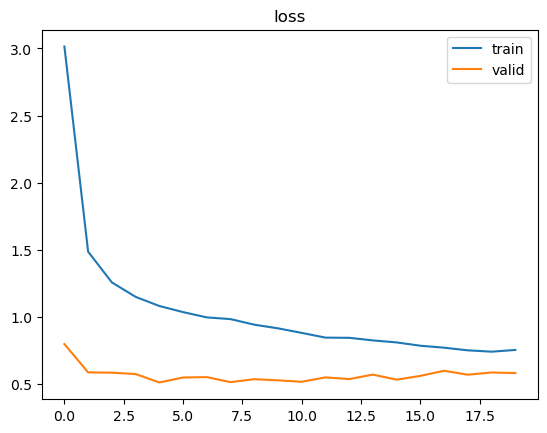

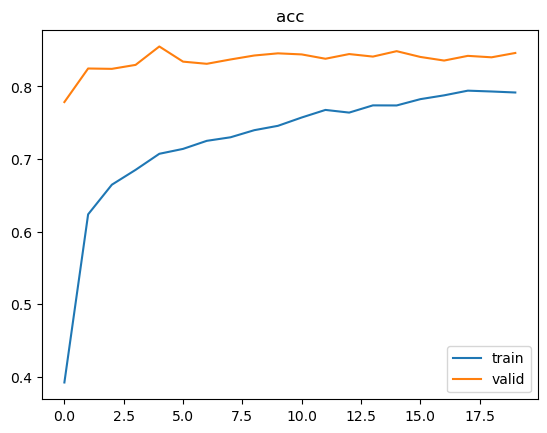

In [33]:
import matplotlib.pyplot as plt
plt.title("loss")
plt.plot(resnet34[0], label='train')
plt.plot(resnet34[1], label='valid')
plt.legend()
plt.show()
plt.title("acc")
plt.plot(resnet34[2], label='train')
plt.plot(resnet34[3], label='valid')
plt.legend()
plt.show()

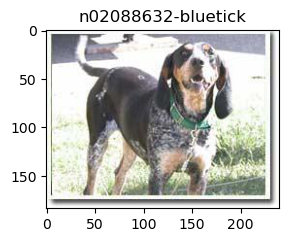

In [29]:
resnet34_model.eval()
with torch.no_grad() :
  outputs = resnet34_model(x_tensor)
  _, y_pred = torch.max(outputs, 1)

  plt.figure(figsize = (3, 3))
  plt.title(class_names[y_pred])
  plt.imshow(ori_img)
  plt.show()

In [30]:
resnet50_model = timm.create_model('resnet50', pretrained = True, num_classes = num_class).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50_model.parameters(), lr = 0.0002)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.9)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [31]:
resnet50 = train_model(resnet50_model, loss_func, optimizer, scheduler, dataloaders, dataset_sizes, device, model_dir, 'dog_resnet50', num_epochs = NUM_EPOCHS)

mps
Epoch 1/20
----------


100%|██████████| 1036/1036 [04:57<00:00,  3.48it/s]


train Loss: 2.2729 Acc: 0.5031


100%|██████████| 126/126 [00:33<00:00,  3.80it/s]


valid Loss: 0.5054 Acc: 0.8487

Epoch 2/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 1.1360 Acc: 0.6982


100%|██████████| 126/126 [00:33<00:00,  3.82it/s]


valid Loss: 0.4406 Acc: 0.8656

Epoch 3/20
----------


100%|██████████| 1036/1036 [04:53<00:00,  3.54it/s]


train Loss: 1.0102 Acc: 0.7258


100%|██████████| 126/126 [00:33<00:00,  3.81it/s]


valid Loss: 0.4320 Acc: 0.8691

Epoch 4/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.9326 Acc: 0.7491


100%|██████████| 126/126 [00:32<00:00,  3.82it/s]


valid Loss: 0.4660 Acc: 0.8596

Epoch 5/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.8946 Acc: 0.7567


100%|██████████| 126/126 [00:33<00:00,  3.82it/s]


valid Loss: 0.4218 Acc: 0.8716

Epoch 6/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.8336 Acc: 0.7692


100%|██████████| 126/126 [00:33<00:00,  3.79it/s]


valid Loss: 0.4391 Acc: 0.8711

Epoch 7/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.7943 Acc: 0.7829


100%|██████████| 126/126 [00:33<00:00,  3.80it/s]


valid Loss: 0.4526 Acc: 0.8671

Epoch 8/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.7777 Acc: 0.7858


100%|██████████| 126/126 [00:33<00:00,  3.81it/s]


valid Loss: 0.4489 Acc: 0.8696

Epoch 9/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.7465 Acc: 0.7933


100%|██████████| 126/126 [00:33<00:00,  3.79it/s]


valid Loss: 0.4824 Acc: 0.8586

Epoch 10/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.7294 Acc: 0.7985


100%|██████████| 126/126 [00:33<00:00,  3.80it/s]


valid Loss: 0.5001 Acc: 0.8586

Epoch 11/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.6895 Acc: 0.8094


100%|██████████| 126/126 [00:33<00:00,  3.80it/s]


valid Loss: 0.4589 Acc: 0.8681

Epoch 12/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.6745 Acc: 0.8155


100%|██████████| 126/126 [00:33<00:00,  3.80it/s]


valid Loss: 0.4689 Acc: 0.8676

Epoch 13/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.55it/s]


train Loss: 0.6588 Acc: 0.8189


100%|██████████| 126/126 [00:33<00:00,  3.79it/s]


valid Loss: 0.4849 Acc: 0.8681

Epoch 14/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.6433 Acc: 0.8240


100%|██████████| 126/126 [00:33<00:00,  3.80it/s]


valid Loss: 0.4865 Acc: 0.8631

Epoch 15/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.6343 Acc: 0.8239


100%|██████████| 126/126 [00:33<00:00,  3.81it/s]


valid Loss: 0.5088 Acc: 0.8616

Epoch 16/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.55it/s]


train Loss: 0.6014 Acc: 0.8340


100%|██████████| 126/126 [00:33<00:00,  3.80it/s]


valid Loss: 0.4753 Acc: 0.8706

Epoch 17/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.5972 Acc: 0.8341


100%|██████████| 126/126 [00:33<00:00,  3.80it/s]


valid Loss: 0.5002 Acc: 0.8736

Epoch 18/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.5958 Acc: 0.8384


100%|██████████| 126/126 [00:33<00:00,  3.79it/s]


valid Loss: 0.5012 Acc: 0.8686

Epoch 19/20
----------


100%|██████████| 1036/1036 [04:51<00:00,  3.55it/s]


train Loss: 0.5932 Acc: 0.8378


100%|██████████| 126/126 [00:33<00:00,  3.80it/s]


valid Loss: 0.5251 Acc: 0.8566

Epoch 20/20
----------


100%|██████████| 1036/1036 [04:52<00:00,  3.54it/s]


train Loss: 0.5562 Acc: 0.8469


100%|██████████| 126/126 [00:33<00:00,  3.79it/s]

valid Loss: 0.5081 Acc: 0.8761

Training complete in 108m 41s
Best val Acc: 0.8761


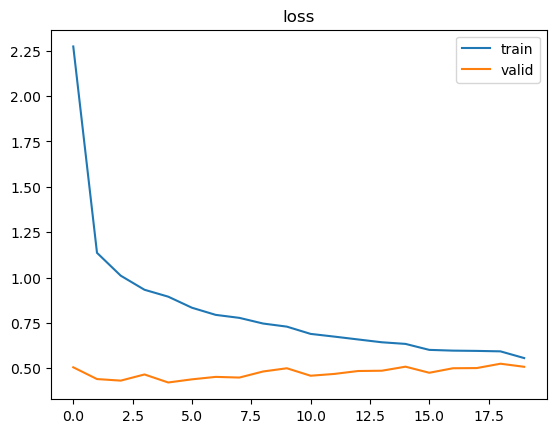

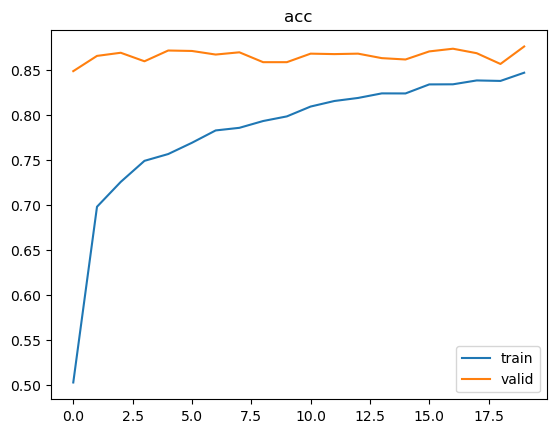

In [32]:
import matplotlib.pyplot as plt
plt.title("loss")
plt.plot(resnet50[0], label='train')
plt.plot(resnet50[1], label='valid')
plt.legend()
plt.show()
plt.title("acc")
plt.plot(resnet50[2], label='train')
plt.plot(resnet50[3], label='valid')
plt.legend()
plt.show()

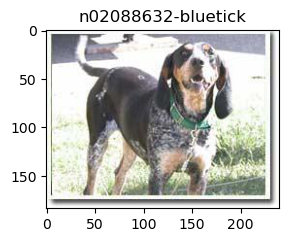

In [34]:
resnet50_model.eval()
with torch.no_grad() :
  outputs = resnet50_model(x_tensor)
  _, y_pred = torch.max(outputs, 1)

  plt.figure(figsize = (3, 3))
  plt.title(class_names[y_pred])
  plt.imshow(ori_img)
  plt.show()